In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns


import os
import shutil
import zipfile

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split



from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [2]:
df_raw = pd.read_csv(r'../data\IN\diabetes.csv')

In [3]:
df_raw.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
cols_drop = ["BloodPressure"]
cols_keep = df_raw.columns[~df_raw.columns.isin(cols_drop)]
predict_col = "Outcome"
df_prepared = df_raw[cols_keep].copy()

# Nulos y duplicados

In [5]:
df_prepared.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df_prepared.duplicated().sum()

np.int64(0)

No tenemos nulos y no tenemos duplicados

## Valores imposibles

Parece que hay datos faltantes que han hecho inscritos como 0 y no como NaN.

In [7]:
columnas_a_imputar_los_zero = ["Glucose", "SkinThickness", "Insulin", "BMI"]
for col in columnas_a_imputar_los_zero:
    median = df_prepared[col][df_prepared[col] != 0].median()
    df_prepared[col] = df_prepared[col].replace(0, median)

In [8]:
df_prepared.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T.sort_values(by='50%', ascending=False).style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Insulin,768.000000,140.671875,86.383060,14.000000,121.500000,125.000000,127.250000,210.000000,293.000000,519.900000,846.000000
Glucose,768.000000,121.656250,30.438286,44.000000,99.750000,117.000000,140.250000,167.000000,181.000000,196.000000,199.000000
BMI,768.000000,32.455208,6.875177,18.200000,27.500000,32.300000,36.600000,41.500000,44.395000,50.759000,67.100000
SkinThickness,768.000000,29.108073,8.791221,7.000000,25.000000,29.000000,32.000000,40.000000,44.000000,51.330000,99.000000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,51.000000,58.000000,67.000000,81.000000
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,9.000000,10.000000,13.000000,17.000000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,0.878600,1.132850,1.698330,2.420000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Manejo de Outliers

## Isolatio forest

In [ ]:
model = IsolationForest(contamination=0.05, random_state=42)


model.fit(df_prepared)


predictions = model.predict(df_prepared)


results = pd.DataFrame(df_prepared, columns=cols_keep)
results["Anomaly"] = predictions


results_filtrado = results[results["Anomaly"] == -1]
results_filtrado.describe(percentiles=[0.25, 0.5, 0.75]).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,39.0,3.974359,4.573880,0.000,0.0000,2.000,7.500,17.00
Glucose,39.0,156.025641,32.902957,57.000,138.0000,163.000,181.000,199.00
SkinThickness,39.0,37.000000,16.465274,7.000,29.0000,37.000,44.000,99.00
Insulin,39.0,316.923077,212.832450,14.000,125.0000,258.000,482.500,846.00
BMI,39.0,38.717949,10.354147,19.600,30.2500,40.000,43.000,67.10
DiabetesPedigreeFunction,39.0,1.013436,0.611921,0.128,0.5985,0.817,1.392,2.42
Age,39.0,39.487179,14.964646,21.000,25.0000,39.000,53.500,67.00
Outcome,39.0,0.589744,0.498310,0.000,0.0000,1.000,1.000,1.00
Anomaly,39.0,-1.000000,0.000000,-1.000,-1.0000,-1.000,-1.000,-1.00


In [10]:
results["Anomaly"].value_counts()

Anomaly
 1    729
-1     39
Name: count, dtype: int64

In [11]:
results["Anomaly"] = results["Anomaly"].astype(int)

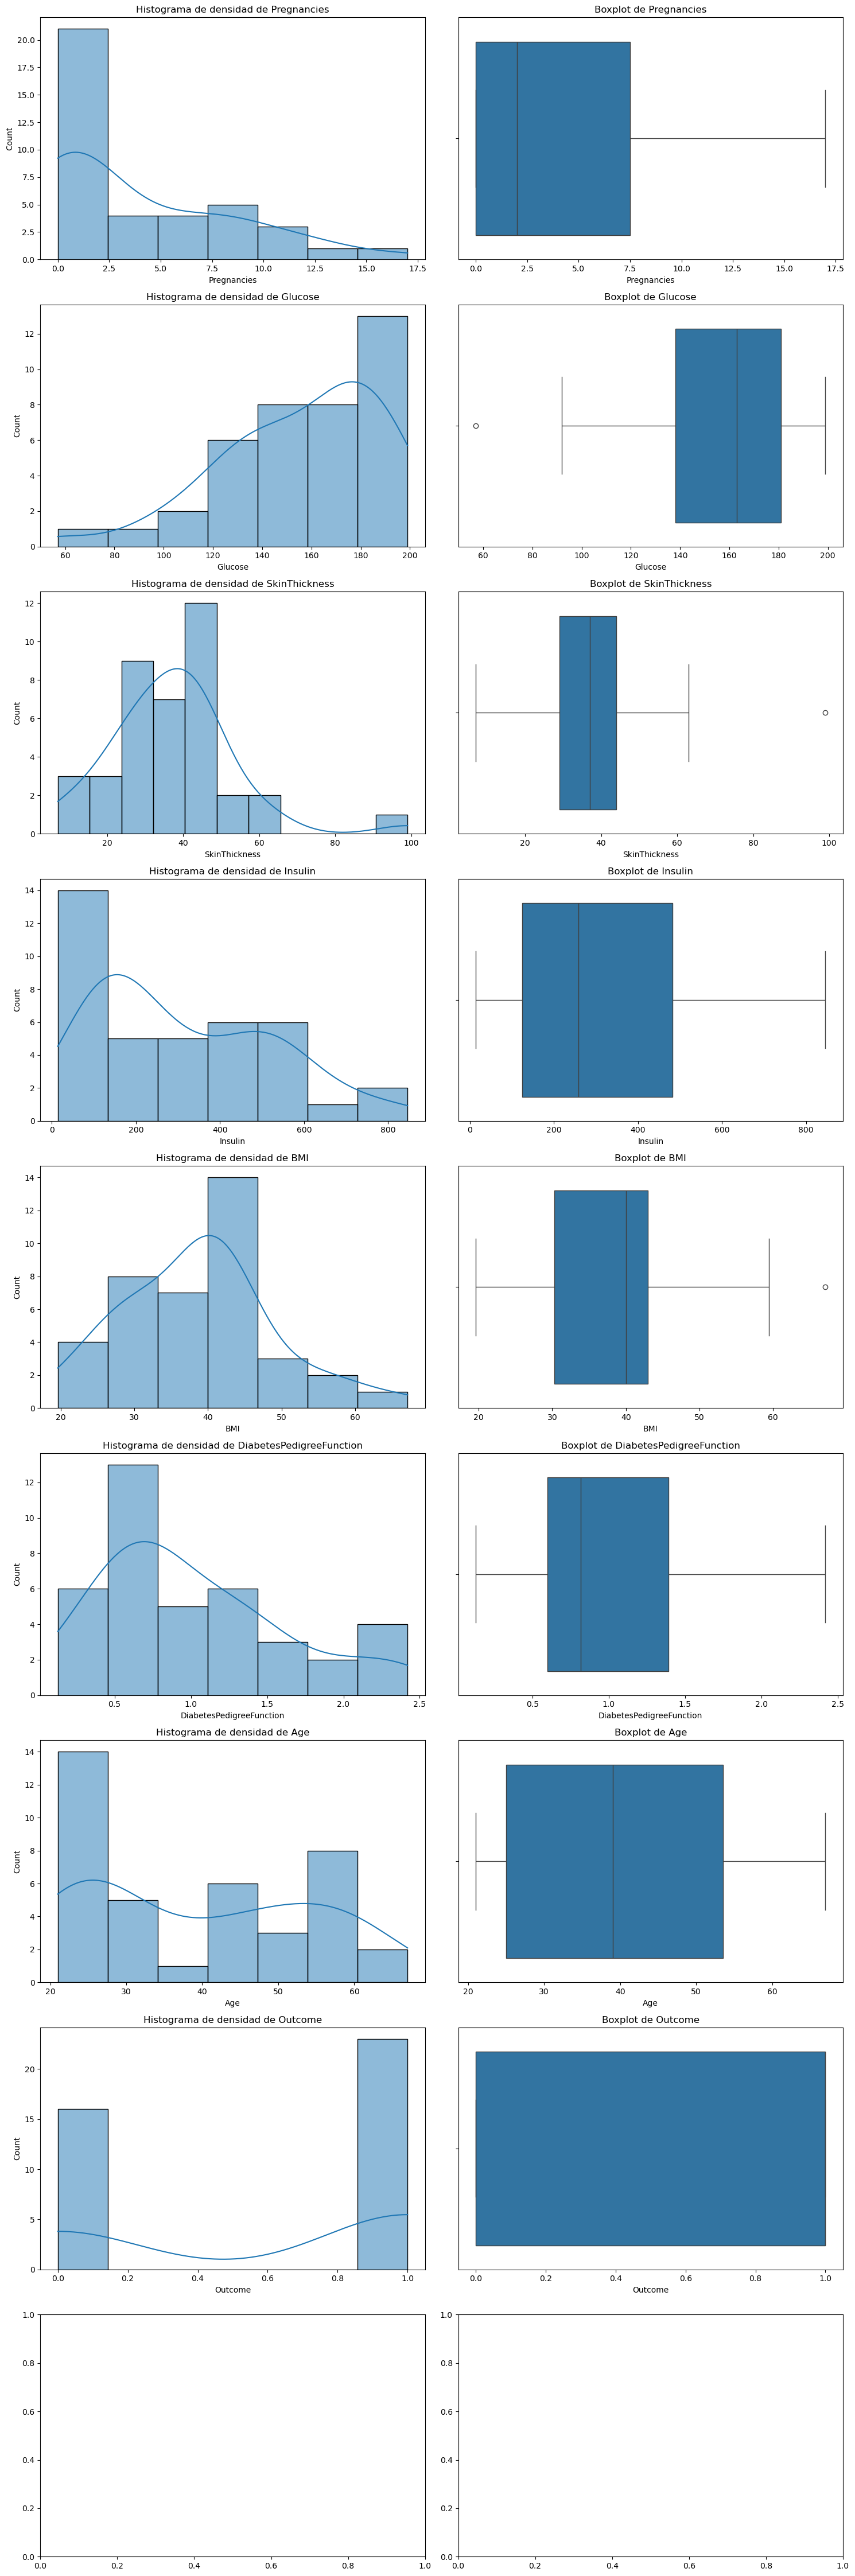

In [ ]:
fig, axes = plt.subplots(nrows=len(results_filtrado.select_dtypes(include=[np.number]).columns), ncols=2, figsize=(15, 5 * len(results_filtrado.select_dtypes(include=[np.number]).columns)))

for i, column in enumerate(results_filtrado[cols_keep]):
  
    sns.histplot(results_filtrado[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
 
    sns.boxplot(x=results_filtrado[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {column}')

plt.tight_layout()
plt.show()

Parece que el isolation forest funciona bien pero como no tenemos sufiecientes registros (quasi 800) no vamos a eliminar los 39 registros y vamos a hacer una windsorizacion de los outliers. 

## Windsorizacion

In [13]:
columnas_windsorizar = df_prepared.columns.drop(["Outcome", "Insulin"])
columnas_sin_target = df_prepared.columns.drop(["Outcome"])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared[columnas_sin_target], df_prepared[predict_col], test_size=0.2, random_state=42, stratify=df_prepared[predict_col])

In [ ]:


def windsorize_iqr(df, columns):

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df


X_train = windsorize_iqr(X_train, columnas_windsorizar)


In [16]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [17]:
X_train["Insulin"] = np.where(X_train["Insulin"] > 500, 500, X_train["Insulin"])

In [18]:
X_train.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T.sort_values(by='50%', ascending=False).style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Insulin,614.000000,136.954397,74.444662,15.000000,120.000000,125.000000,130.000000,206.400000,276.750000,495.000000,500.000000
Glucose,614.000000,121.671010,30.003794,56.000000,99.000000,117.000000,140.000000,167.000000,180.350000,196.000000,199.000000
BMI,614.000000,32.383042,6.609198,18.200000,27.625000,32.300000,36.500000,41.210000,44.035000,49.797875,49.812500
Age,614.000000,33.319218,11.681606,21.000000,24.000000,29.000000,41.000000,51.000000,58.000000,66.000000,66.500000
SkinThickness,614.000000,28.821661,7.502444,14.500000,25.000000,29.000000,32.000000,40.000000,42.500000,42.500000,42.500000
Pregnancies,614.000000,3.812704,3.291930,0.000000,1.000000,3.000000,6.000000,9.000000,10.000000,13.000000,13.500000
DiabetesPedigreeFunction,614.000000,0.466070,0.290059,0.084000,0.245000,0.382500,0.639250,0.890200,1.130150,1.230625,1.230625


# Normalizacion

In [19]:
robust_scaler = RobustScaler()
columnas_a_normalizar = df_prepared.columns.drop(["Outcome"])
X_train[columnas_a_normalizar] = robust_scaler.fit_transform(X_train[columnas_a_normalizar])

In [20]:
X_test[columnas_a_normalizar] = robust_scaler.transform(X_test[columnas_a_normalizar])

In [21]:
X_train.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,-0.4,-0.658537,-2.071429,-8.2,-0.574648,0.500951,-0.294118
711,0.4,0.219512,-0.285714,-10.3,-0.304225,0.143310,0.647059
373,-0.2,-0.292683,1.571429,-3.1,0.292958,-0.399493,-0.235294
46,-0.4,0.707317,0.000000,0.0,-0.292958,0.460368,0.000000
682,-0.6,-0.536585,1.428571,-2.0,1.385915,-0.041852,-0.411765


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [23]:
df_train = pd.concat([X_train, y_train], axis=1)
df_valid = pd.concat([X_valid, y_valid], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [24]:
df_train.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [25]:
df_train.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
216,0.4,-0.195122,1.714286,0.4,0.394366,0.333545,-0.235294,1
498,0.8,1.902439,0.571429,2.0,-0.811268,-0.556753,1.529412,1
550,-0.4,-0.024390,-0.142857,0.0,-0.552113,-0.452758,-0.470588,0
217,0.6,0.195122,0.142857,-0.5,-0.259155,0.206722,0.176471,0
729,-0.2,-0.609756,0.000000,0.0,-0.247887,-0.612555,-0.411765,0


In [26]:
OUTPUT_FOLDER = "../data/OUT/"

def save_dataframes_to_csv(output_folder, df_train, train_filename="diabetes_clean.csv"):
    """
    Guarda los DataFrames de entrenamiento y prueba en formato CSV en una carpeta específica.
    Si la carpeta ya existe, borra todo su contenido antes de guardar los nuevos archivos.
    
    Args:
        output_folder (str): La ruta de la carpeta donde se guardarán los archivos CSV.
        df_train (pd.DataFrame): El DataFrame de entrenamiento que se va a guardar.
        df_test (pd.DataFrame): El DataFrame de prueba que se va a guardar.
        train_filename (str, opcional): El nombre del archivo CSV para el DataFrame de entrenamiento.
        test_filename (str, opcional): El nombre del archivo CSV para el DataFrame de prueba.
    
    """
    
    # Crear la carpeta si no existe
    os.makedirs(output_folder, exist_ok=True)
    
    # Definir las rutas completas de los archivos
    train_path = os.path.join(output_folder, train_filename)
    
    # Guardar los DataFrames en formato CSV
    df_train.to_csv(train_path, index=False)
    
    print(f"DataFrames guardados en {output_folder}:")
    print(f" - {train_filename}")


save_dataframes_to_csv(OUTPUT_FOLDER, df_train, train_filename="diabetes_train.csv")
save_dataframes_to_csv(OUTPUT_FOLDER, df_valid, train_filename="diabetes_valid.csv")
save_dataframes_to_csv(OUTPUT_FOLDER, df_test, train_filename="diabetes_test.csv")

DataFrames guardados en ../data/OUT/:
 - diabetes_train.csv
DataFrames guardados en ../data/OUT/:
 - diabetes_valid.csv
DataFrames guardados en ../data/OUT/:
 - diabetes_test.csv


In [27]:
import joblib
joblib.dump(robust_scaler, 'robust_scaler.joblib')

['robust_scaler.joblib']